In [30]:
%load_ext autoreload
%autoreload 2
import re
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
import random as rand
from ipywidgets import *
import colorlover as cl
from scipy import stats
import importlib
import sys
sys.path.append(os.getcwd()+'\\..')
from utils import utils
from utils import plot_utils_fig2p5 as pu
from utils import zscores
import matplotlib.patches as patches
from matplotlib import gridspec

import matplotlib.patches as patch
from Aggregate_logs import aggregate_logs
from process_microstim import process_opto
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=14)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
size_mult = 1

#### Load, concatenate, save data across sessions

In [32]:
data_directory = r'C:\Users\efink\Documents\DATA\Inhibition sessions'

In [33]:
os.chdir(data_directory)
log_df, opto_df = aggregate_logs(data_directory)

HBox(children=(IntProgress(value=0, max=73), HTML(value='')))

HBox(children=(IntProgress(value=0, max=73), HTML(value='')))

C:\Users\efink\Anaconda3\lib\site-packages\pandas\core\generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['mouse_name', 'date', 'block_type', 'trial_type', 'touch_stimulus', 'vis_stimulus', 'licks_right', 'licks_left', 'spike_times', 'cluster_name', 'spike_times(stim_aligned)', 'identified']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
C:\Users\efink\Anaconda3\lib\site-packages\pandas\core\generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['mouse_name', 'date', 'cluster_name', 'opto_stim_onsets', 'opto_stim_offsets', 'first_last_opto_pulses', 'grouped_opto_pulses']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [34]:
log_df, unit_key_df = utils.load_data(data_directory)

In [35]:
unique_sessions = log_df[['mouse_name', 'date']].drop_duplicates().sort_values(['mouse_name', 'date'])
list(unique_sessions['date'].groupby(unique_sessions['mouse_name']))

[('EF0114', 0         06-19-18
  1911      06-20-18
  3248     06-20-18b
  5480     06-21-18b
  7757      06-22-18
  9809      06-26-18
  12161     06-27-18
  16889     06-29-18
  23159     06-30-18
  26087     07-01-18
  29243     07-02-18
  33559     07-03-18
  36265     07-09-18
  39037     07-10-18
  41185     07-11-18
  44197     07-12-18
  49215     07-14-18
  54128     07-16-18
  Name: date, dtype: object), ('EF0131', 59313      07-02-18
  60885      07-03-18
  62289      07-07-18
  62656      07-09-18
  65176     07-09-18b
  65830      07-10-18
  67874      07-12-18
  69722      07-14-18
  72532      07-16-18
  78427      07-17-18
  90631      07-18-18
  99939      07-19-18
  106365     07-20-18
  108843     07-21-18
  110817     07-23-18
  113353     07-24-18
  117223     07-26-18
  Name: date, dtype: object), ('EF0132', 120184    07-08-18
  122328    07-10-18
  122964    07-11-18
  123278    07-12-18
  123560    07-14-18
  124860    07-17-18
  127191    07-18-18
  130053    0

In [36]:
sham_days = {'EF0131': ['07-01-18', '07-07-18', '07-09-18b', '07-12-18', '07-19-18', '07-23-18', '07-26-18'], 
             'EF0114': ['07-11-18', '07-12-18', '07-14-18'], 
             'EF0132': ['07-11-18', '07-17-18', '07-21-18', '07-25-18'],
             'EF0144': ['08-15-18','08-22-18', '08-25-18', '08-30-18'],
            'YT045':['07-14-18','07-27-18','08-06-18','08-30-18']}

In [37]:
log_df['stim_duration'] = (log_df['stim_offset']-log_df['stim_onset']).round(2)

In [38]:
sham_df = pd.concat([pd.DataFrame({key:arr}).melt() for key, arr in sham_days.items()])
sham_df = sham_df.rename(columns = {'variable': 'mouse_name', 'value':'date'})
sham_df['session_type'] = 'sham'
log_df_sham = sham_df.merge(log_df, on = ['mouse_name', 'date'], how = 'left')
log_df_sham = log_df_sham.dropna(axis = 0, subset = ['trial_num'])

In [39]:
non_sham_rows = ~log_df['uni_id'].isin(log_df_sham['uni_id'])
non_sham_days = log_df.loc[non_sham_rows].groupby(['mouse_name', 'date'])
non_sham_df = non_sham_days['stim_duration'].max().reset_index()
non_sham_df = non_sham_df.rename(columns = {'stim_duration':'session_type'})
non_sham_df.loc[non_sham_df['session_type'] == 0.15, 'session_type'] = 'long'
non_sham_df.loc[non_sham_df['session_type'] == 0.05, 'session_type'] = 'short'
log_df_nonsham = log_df.merge(non_sham_df, on = ['mouse_name', 'date'], how = 'right')
log_df_nonsham.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164196 entries, 0 to 164195
Data columns (total 23 columns):
mouse_name                   164196 non-null object
date                         164196 non-null object
block_type                   164196 non-null object
trial_type                   164196 non-null object
touch_stimulus               164196 non-null object
vis_stimulus                 164196 non-null object
response                     164196 non-null int64
trial_num                    164196 non-null int64
trial_onset                  164196 non-null float64
stim_onset                   164196 non-null float64
stim_offset                  131842 non-null float64
licks_right                  164196 non-null object
licks_left                   164196 non-null object
spike_times                  164196 non-null object
cluster_name                 164196 non-null object
spike_times(stim_aligned)    164196 non-null object
first_lick                   70522 non-null float64
last

In [40]:
log_df = pd.concat([log_df_sham, log_df_nonsham]).reset_index(drop = True)

In [41]:
opto_df_pulses = opto_df.drop_duplicates(['mouse_name', 'date'])[['mouse_name', 'date', 'opto_stim_onsets']]

### Label groups of trials based on opto-stim type

In [42]:
def find_pulse(trial_start, opto_onsets):
    if trial_start > opto_onsets[-1]:
        pulse = np.nan
    else:
        pulse = min(opto_onsets[opto_onsets>trial_start])
    return pulse

In [43]:
log_df = log_df.merge(opto_df_pulses, how = 'left', on = ['mouse_name', 'date'])

In [44]:
log_df['opto_stim_onsets'] = log_df.apply(lambda x: find_pulse(x['trial_onset'], x['opto_stim_onsets']), axis = 1)
log_df['opto_stim_onsets'] = np.abs(np.round(log_df['opto_stim_onsets'] - log_df['trial_onset'] - log_df['stim_onset'], 2))
log_df.loc[log_df['trial_type'].str.contains('NoCue'), 'opto_stim_onsets'] = 'No_laser'
log_df.loc[log_df['trial_type'].str.contains('catch'), 'stim_onset'] = log_df['opto_stim_onsets']
log_df.loc[log_df['trial_type'].str.contains('catch'), 'opto_stim_onsets'] = 1
log_df[['trial_type', 'opto_stim_onsets']].head()

,trial_type,opto_stim_onsets
0,Stim_Som_NoCue,No_laser
1,catch,1
2,catch,1
3,Stim_Som_NoCue,No_laser
4,Stim_Som_NoCue,No_laser


In [45]:
catch_idx = log_df['trial_type'].str.contains('catch')
log_df.loc[catch_idx, 'spike_times(stim_aligned)'] = log_df.loc[catch_idx,'spike_times'] - log_df.loc[catch_idx,'stim_onset']

In [46]:
def edit_grp_names(name):
    name = list(name)
    name[1] = re.sub(r'(.*Som\b|.*Vis\b)', r'\1', name[1])
    name[1] = re.sub(r'(.*)_NoCue\b', r'\1', name[1])
    return tuple(name)

In [47]:
all_beh = log_df.drop_duplicates(['mouse_name', 'date','trial_num']).copy()
all_beh.head()

,block_type,cluster_name,correct,date,first_lick,identified,last_lick,licks_left,licks_right,mouse_name,...,stim_duration,stim_offset,stim_onset,touch_stimulus,trial_num,trial_onset,trial_type,uni_id,vis_stimulus,opto_stim_onsets
0,Visual,TT5clst1,0.0,07-07-18,0.125367,unidentified,0.420833,"[1.8884666666666667, 2.0638666666666667, 9.783...",[],EF0131,...,0.15,9.805367,9.6578,SineAmp1p000Freq20Cyc3,284.0,2789.360900,Stim_Som_NoCue,13107-07-185t1,Amp0p5Dur0p150,No_laser
1,Whisker,TT5clst1,0.0,07-07-18,0.150667,unidentified,0.496200,[],"[0.004333333333333333, 0.15066666666666667, 0....",EF0131,...,NaN,NaN,2.81,SineAmp1p000Freq20Cyc3,86.0,862.047033,catch,13107-07-185t1,Amp0p5Dur0p150,1
2,Whisker,TT5clst1,0.0,07-07-18,0.173900,unidentified,0.173900,[],"[0.022733333333333335, 0.1739, 3.9772333333333...",EF0131,...,NaN,NaN,6.57,SineAmp1p000Freq20Cyc3,70.0,689.279567,catch,13107-07-185t1,Amp0p5Dur0p150,1
3,Whisker,TT5clst1,1.0,07-07-18,0.198600,unidentified,1.161333,[1.1734],"[0.31013333333333337, 0.42923333333333336, 7.5...",EF0131,...,0.15,7.575367,7.4279,SineAmp1p000Freq20Cyc3,331.0,3233.930300,Stim_Som_NoCue,13107-07-185t1,Amp0p5Dur0p150,No_laser
4,Visual,TT5clst1,0.0,07-07-18,0.213100,unidentified,0.593033,"[1.3416666666666668, 1.7216, 5.615633333333333]",[],EF0131,...,0.15,1.276033,1.12857,SineAmp1p000Freq20Cyc3,267.0,2628.673800,Stim_Som_NoCue,13107-07-185t1,Amp0p5Dur0p150,No_laser


### List how many sessions were recorded for each mouse and session type

In [48]:
all_beh[['mouse_name', 'date', 'session_type']].drop_duplicates().groupby(['mouse_name', 'session_type']).size()

mouse_name  session_type
EF0114      long            8
            sham            3
            short           7
EF0131      long            7
            sham            6
            short           4
EF0132      long            7
            sham            3
            short           4
EF0144      long            4
            sham            4
            short           4
YT045       long            6
            sham            3
            short           3
dtype: int64

In [49]:
def sum_lick_trials(df):
    
    grpby_trial_type = df.groupby(['block_type','trial_type'])
    lick_trials = {tt:{'Lick':sum(rows['response'] !=0), 'No_Lick':sum(rows['response'] ==0)} for tt, rows in grpby_trial_type}
    return pd.DataFrame(lick_trials)

def lick_ratio(df):
    
    grpby_trial_type = df.groupby(['block_type','trial_type'])
    lick_ratios = {tt:sum(rows['response'] !=0)/rows['response'].shape[0] for tt, rows in grpby_trial_type}
    return pd.Series(lick_ratios)

def plot_licks(lick_df, ax, session):

    for block, xpos in zip(['Visual', 'Whisker'], [np.arange(5), np.arange(6,11)]):
        sub_df = lick_df[block]
        ax.bar(xpos[0:len(sub_df.loc['Lick', :])], sub_df.loc['Lick', :], color = 'g', alpha = 0.7)
        ax.bar(xpos[0:len(sub_df.loc['No_Lick', :])], sub_df.loc['No_Lick', :],
               bottom = sub_df.loc['Lick', :], color = [0.4,0.4,0.4], alpha =0.3)
    
    ax.add_patch(patches.Rectangle((-1, -10), 6, 10, color = 'C1', alpha = 0.7))
    ax.add_patch(patches.Rectangle((5, -10), 6, 10, color = 'C0', alpha = 0.7))
    ax.set_ylim(-5, 90)
    xticks = ['Touch + laser', 'Touch', 'Visual + laser', 'Visual', 'laser']*2
    ax.set_xticks([0,1,2,3,4,6,7,8,9,10])
    ax.set_xticklabels(xticks, rotation = 65, ha = 'right')
    ax.set_title(session)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

### Calculate mean and standard deviation of hit rate for each trial type across sessions using bootstrap resampling

In [50]:
def bootstrap_means(df,random_state = 42, replace = True):
    ## resamples with replacement all the trials within a session_type but across days (ie sham or long stim inhibition). 
    ## Then calculates mean lick rate for the trial type
    
    df = df.sample(frac = 1, replace = replace, random_state = random_state)
    grps = df.groupby(['block_type','trial_type', 'opto_stim_onsets'])
    inds = grps.groups
    grp_names = list(inds.keys())
    grp_responses = {grp:(df.loc[inds[grp],'response']!=0).values for grp in grp_names}

    grp_means = {name:[np.mean(grp)] for name, grp in grp_responses.items()}
#     grp_names = [edit_grp_names(grp) for grp in grp_names]
#     import pdb; pdb.set_trace()

    grp_means = {name:value for name, value in zip(grp_names, grp_means.values())}

    return pd.DataFrame(grp_means)

In [51]:
def calc_grp_means(df):
    
    samp_mean = bootstrap_means(df, replace = False).T
    resamp_means = pd.concat([bootstrap_means(df, random_state = n) for n in range(1000)])
    resamp_means = resamp_means.reset_index(drop = True)
#     means = resamp_means
    sem = resamp_means.apply(lambda x: np.std(x), axis = 0)
    return samp_mean.loc[:, 0], sem

In [52]:
all_beh.loc[:, 'inhibition_session'] = 'sham'
all_beh.loc[all_beh['session_type'].isin(['long', 'short']), 'inhibition_session'] = 'inh'
all_beh = all_beh.loc[all_beh['opto_stim_onsets'].isin([0.05, 0, 1, 'No_laser']), :] ## if stim was dropped due to premature lick opto onset gets labeled as longer than 0.05 - remove these
all_beh.loc[all_beh['trial_type'].str.contains('Som'), 'trial_type'] = 'Stim_Som' ## No_laser condition always has Stim_Som_NoCue/Stim_Vis_NoCuein trial_type name - remove _NoCue
all_beh.loc[all_beh['trial_type'].str.contains('Vis'), 'trial_type'] = 'Stim_Vis'

beh_grouped = all_beh.groupby(['mouse_name','inhibition_session'])
beh_grouped_split = all_beh.groupby(['mouse_name', 'session_type'])

In [53]:
grpd = iter(beh_grouped)

In [54]:
beh_performance = {mouse:calc_grp_means(grp) for mouse,grp in tqdm_notebook(beh_grouped)}

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [55]:
beh_performance_split = {mouse:calc_grp_means(grp) for mouse,grp in tqdm_notebook(beh_grouped_split)}

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

In [56]:
# bs_means, sem = calc_grp_means(all_beh_nosham)
# bs_means_sham, sem_sham = calc_grp_means(all_beh_sham)

In [511]:
def plot_perf(bs_means, sem, ax1, ax2):
    
#     ex_group = next(iter(bs_means)) # used to order trial_types
    trial_types = pd.DataFrame(np.vstack(bs_means.keys()))
    trial_types = trial_types.sort_values([0,1,2], ascending=False)
    trial_types.replace('1', 1, inplace= True)
    trial_types.replace('0.0', 0, inplace= True)
    trial_types.replace('0.05', 0.05, inplace= True)
    trial_type_order = [tuple(tt) for tt in trial_types.values]
    
    bs_means_dict = bs_means.to_dict()
    sem_dict = sem.to_dict()
    colors = ['k', 'C1', 'C1', 'C1', 'C0', 'C0', 'C0']*2
    whisker_grps = {}; visual_grps = {}
    for i, grp in enumerate(trial_type_order):

        mean = bs_means_dict[grp]
        sem_grp = sem_dict[grp]

        grp = list(grp)
        grp[2] = str(grp[2])
        
        if grp[1] == 'catch':
            grp.pop(2)

        if grp[0] == 'Whisker':
            
#             ax1.set_title('Whisker Block')
            ax1.scatter(' - '.join(grp[1:]), mean, color = colors[i], s = 65, alpha = 0.7)
            ax1.vlines(' - '.join(grp[1:]), mean-sem_grp, mean+sem_grp, color = colors[i])
            ax1.set_ylim(0,1)
            mpl.sca(ax1); mpl.xticks( rotation = '45', ha = 'right')
            whisker_grps[' - '.join(grp[1:])] = mean 
        else:
#             ax2.set_title('Visual Block')
            ax2.scatter(' - '.join(grp[1:]), mean, color = colors[i], s = 65, alpha = 0.7)
            ax2.vlines(' - '.join(grp[1:]), mean-sem_grp, mean+sem_grp, color = colors[i])
            ax2.set_ylim(0,1)
            visual_grps[' - '.join(grp[1:])] = mean 
            mpl.sca(ax2); mpl.xticks(rotation = 'vertical'); mpl.xticks(rotation = '45', ha = 'right')
            
    ax1.plot(whisker_grps.keys(), whisker_grps.values(), color = [0.4, 0.4, 0.4], ls = 'solid', alpha = 0.3)
    ax2.plot(visual_grps.keys(), visual_grps.values(), color = [0.4, 0.4, 0.4], ls = 'solid', alpha = 0.3)
    
    ax1.set_ylabel('Lick rate')
    
    for ax in [ax1,ax2]:
        ax.set_xticklabels(['No offset   ', 'No manipulation', '50 ms offset    ', '50 ms offset    ',
                             'No offset    ', 'No manipulation', '50 ms offset     ', '50 ms offset    '])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    mpl.subplots_adjust(bottom=0.35)

In [59]:
def select_treatment_group(data, treatment, group):
    inh_groups = {key[0]:data[key][0] for key in data.keys() if key[1] == treatment}
    del(inh_groups['YT045'])
#     del(inh_groups['EF0132'])
    mouse_means = [inh_groups[mouse][group] for mouse in inh_groups.keys()]
    return mouse_means

No laser/late inhibition t-test: 0.0052124985980008965
No laser/full inhibition t-test: 0.007244219841655084



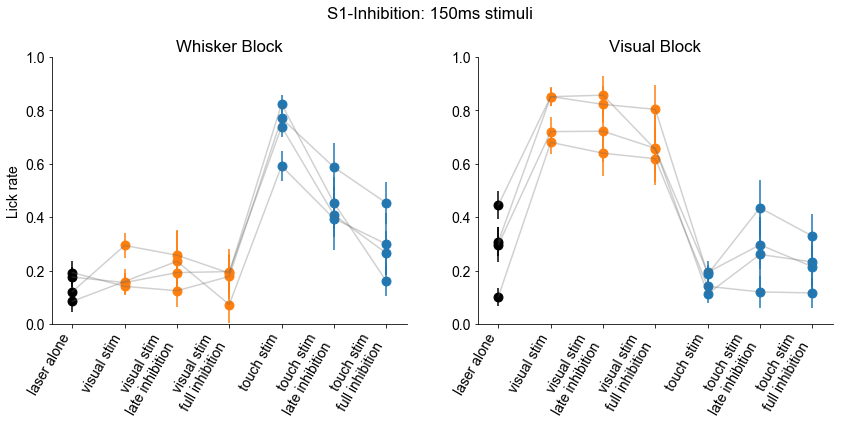

In [60]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize = (14,7))
plot_perf(beh_performance_split[('EF0114', 'long')][0],beh_performance_split[('EF0114', 'long')][1], ax1,ax2)
plot_perf(beh_performance_split[('EF0131', 'long')][0],beh_performance_split[('EF0131', 'long')][1], ax1,ax2)
plot_perf(beh_performance_split[('EF0132', 'long')][0],beh_performance_split[('EF0132', 'long')][1], ax1,ax2)
plot_perf(beh_performance_split[('EF0144', 'long')][0],beh_performance_split[('EF0144', 'long')][1], ax1,ax2)

# plot_perf(beh_performance[('YT045', 'long')][0],beh_performance[('YT045', 'long')][1], ax1,ax2)
fig.suptitle('S1-Inhibition: 150ms stimuli')
# fig.savefig('fig_inh_long.png', format='png', dpi=600)

cond1 = select_treatment_group(beh_performance_split, 'long', ('Whisker', 'Stim_Som', 'No_laser'))
cond2 = select_treatment_group(beh_performance_split, 'long', ('Whisker', 'Stim_Som', 0.05))
cond3 = select_treatment_group(beh_performance_split, 'long', ('Whisker', 'Stim_Som', 0.0))
no_laser_vs_late = stats.ttest_rel(cond1, cond2)
no_laser_vs_full = stats.ttest_rel(cond1, cond3)

print('No laser/late inhibition t-test: {}\nNo laser/full inhibition t-test: {}\n'.format(no_laser_vs_late.pvalue/2, no_laser_vs_full.pvalue/2))


No laser/late inhibition t-test: 0.10470597285892767
No laser/full inhibition t-test: 0.0002495367925779327



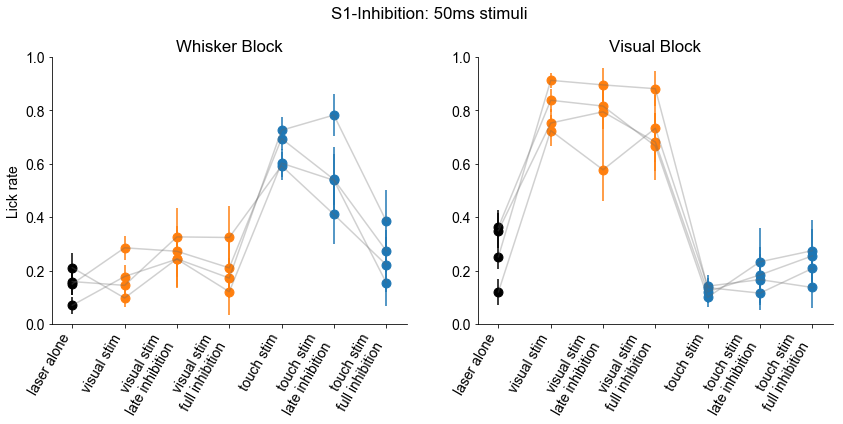

In [61]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize = (14,7))

plot_perf(beh_performance_split[('EF0114', 'short')][0],beh_performance_split[('EF0114', 'short')][1], ax1,ax2)
plot_perf(beh_performance_split[('EF0131', 'short')][0],beh_performance_split[('EF0131', 'short')][1], ax1,ax2)
plot_perf(beh_performance_split[('EF0132', 'short')][0],beh_performance_split[('EF0132', 'short')][1], ax1,ax2)
plot_perf(beh_performance_split[('EF0144', 'short')][0],beh_performance_split[('EF0144', 'short')][1], ax1,ax2)

fig.suptitle('S1-Inhibition: 50ms stimuli')
# fig.savefig('fig_inh_short.png', format='png', dpi=600)

cond1 = select_treatment_group(beh_performance_split, 'short', ('Whisker', 'Stim_Som', 'No_laser'))
cond2 = select_treatment_group(beh_performance_split, 'short', ('Whisker', 'Stim_Som', 0.05))
cond3 = select_treatment_group(beh_performance_split, 'short', ('Whisker', 'Stim_Som', 0.0))
no_laser_vs_late = stats.ttest_rel(cond1, cond2)
no_laser_vs_full = stats.ttest_rel(cond1, cond3)

print('No laser/late inhibition t-test: {}\nNo laser/full inhibition t-test: {}\n'.format(no_laser_vs_late.pvalue/2, no_laser_vs_full.pvalue/2))


In [166]:
columns = ['mouse_name', 'block_type','trial_type','response', 'correct', 'opto_stim_onsets']
columns.append('lick')


In [200]:
inh_session_outcomes['inhibition_session'].value_counts()

inh    16671
Name: inhibition_session, dtype: int64

In [417]:
columns = ['mouse_name', 'block_type','trial_type','response', 'correct', 'opto_stim_onsets', 'lick']
inh_session_outcomes = all_beh.loc[all_beh['inhibition_session'] == 'inh',:].copy()
inh_session_outcomes.loc[:,'lick'] = (inh_session_outcomes['response'] != 0)*1
columns.append('lick')

sham_session_outcomes = all_beh.loc[all_beh['inhibition_session'] == 'sham',:].copy()
sham_session_outcomes.loc[:,'lick'] = (sham_session_outcomes['response'] != 0)*1


grouped_correct_licks = inh_session_outcomes[columns].groupby(['mouse_name', 'block_type','trial_type','opto_stim_onsets'])
grouped_correct_licks_sham = sham_session_outcomes[columns].groupby(['mouse_name', 'block_type','trial_type','opto_stim_onsets'])


def multilevel_bootstrap(gr_df, gr1, gr2, num_iter):
    
    all_resampled_stats = []
    for i in tnrange(num_iter):

        across_mice_resample = []

        ##### resample mice with replacement ###############
        mice = ['EF0114', 'EF0132', 'EF0131', 'EF0144']
        resamp_mice = np.random.choice(mice, size = len(mice), replace = True)

        for mouse in resamp_mice:
            ############# stratefied resampling of trials within mouse with replacement ###########
            gr_2 = tuple([mouse]  + gr2)
            gr_1 = tuple([mouse]  + gr1)
            #queries gr_df for groups we want to compare
            cond1 = gr_df.get_group(gr_1) 
            cond2 = gr_df.get_group(gr_2)

            cond1_resample = cond1.sample(frac = 1, replace = True,)
            cond2_resample = cond2.sample(frac = 1, replace = True,)

            mouse_lick_prob_diff = cond2_resample['lick'].mean() - cond1_resample['lick'].mean()
            across_mice_resample.append(mouse_lick_prob_diff)

        all_resampled_stats.append(np.mean(across_mice_resample))
        
    sorted_stats = np.sort(all_resampled_stats)
    return sorted_stats

In [418]:
num_iter = 10000
inh_stats = {
    'tac_nolaser_0':multilevel_bootstrap(grouped_correct_licks, ['Whisker', 'Stim_Som', 'No_laser'], ['Whisker', 'Stim_Som', 0], num_iter = num_iter),
    'tac_nolaser_50':multilevel_bootstrap(grouped_correct_licks, ['Whisker', 'Stim_Som', 'No_laser'], ['Whisker', 'Stim_Som', 0.05], num_iter = num_iter),
    'vis_nolaser_0':multilevel_bootstrap(grouped_correct_licks, ['Visual', 'Stim_Vis', 'No_laser'], ['Visual', 'Stim_Vis', 0], num_iter = num_iter),
    'vis_nolaser_50':multilevel_bootstrap(grouped_correct_licks, ['Visual', 'Stim_Vis', 'No_laser'], ['Visual', 'Stim_Vis', 0.05], num_iter = num_iter),
}


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [419]:
sham_stats = {
    'tac_nolaser_0':multilevel_bootstrap(grouped_correct_licks_sham, ['Whisker', 'Stim_Som', 'No_laser'], ['Whisker', 'Stim_Som', 0], num_iter = num_iter),
    'tac_nolaser_50':multilevel_bootstrap(grouped_correct_licks_sham, ['Whisker', 'Stim_Som', 'No_laser'], ['Whisker', 'Stim_Som', 0.05], num_iter = num_iter),
    'vis_nolaser_0':multilevel_bootstrap(grouped_correct_licks_sham, ['Visual', 'Stim_Vis', 'No_laser'], ['Visual', 'Stim_Vis', 0], num_iter = num_iter),
    'vis_nolaser_50':multilevel_bootstrap(grouped_correct_licks_sham, ['Visual', 'Stim_Vis', 'No_laser'], ['Visual', 'Stim_Vis', 0.05], num_iter = num_iter),
}

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [420]:
def calc_mean_diff(label,mouse_session):
    diff_stats = {
        'mouse':[label[0]],
        'session':[label[1]],
        'tac_nolaser_0': mouse_session[0][('Whisker', 'Stim_Som', 0)]-mouse_session[0][('Whisker', 'Stim_Som', 'No_laser')],
        'tac_nolaser_50':mouse_session[0][('Whisker', 'Stim_Som', 0.05)]-mouse_session[0][('Whisker', 'Stim_Som', 'No_laser')],
        'vis_nolaser_0':mouse_session[0][('Visual', 'Stim_Vis', 0)]-mouse_session[0][('Visual', 'Stim_Vis', 'No_laser')],
        'vis_nolaser_50':mouse_session[0][('Visual', 'Stim_Vis', 0.05)]-mouse_session[0][('Visual', 'Stim_Vis', 'No_laser')]
    }
    return pd.DataFrame.from_dict(diff_stats)
    
mean_diffs = pd.concat([calc_mean_diff(label, mouse_session) for label, mouse_session in beh_performance.items()]).reset_index(drop = True)

In [362]:
mean_diffs

,mouse,session,tac_nolaser_0,tac_nolaser_0.05,vis_nolaser_0,vis_nolaser_0.05
0,EF0114,inh,0.549126,0.263292,0.130820,0.005722
1,EF0114,sham,0.072549,0.088889,0.028125,0.032670
2,EF0131,inh,0.428630,0.268907,0.096491,0.026179
3,EF0131,sham,-0.093701,-0.074754,0.161026,0.107165
4,EF0132,inh,0.319149,0.073921,0.040593,0.079840
5,EF0132,sham,-0.043860,-0.062378,0.110897,0.059058
6,EF0144,inh,0.374198,0.134313,0.065963,-0.023305
7,EF0144,sham,-0.063571,0.084184,-0.006061,0.092979
8,YT045,inh,0.277509,0.109818,-0.013699,-0.025603
9,YT045,sham,0.031933,-0.168067,-0.086957,0.079710


In [363]:
inh_stats

{'tac_nolaser_0': array([0.27062664, 0.274209  , 0.28187175, ..., 0.57217806, 0.5745628 ,
        0.58076312]),
 'tac_nolaser_50': array([0.00459569, 0.02458064, 0.02594871, ..., 0.31464707, 0.31535029,
        0.31681306]),
 'vis_nolaser_0': array([-0.03601446, -0.02776709, -0.02461738, ...,  0.17411714,
         0.17434484,  0.17612958]),
 'vis_nolaser_50': array([-0.10187675, -0.09064426, -0.08547726, ...,  0.12775975,
         0.13187782,  0.13370813])}

In [380]:
sham_stats

{'tac_nolaser_0': array([0.26507092, 0.26941008, 0.2748227 , ..., 0.57972973, 0.58410175,
        0.59149444]),
 'tac_nolaser_50': array([0.02400873, 0.02782852, 0.03433725, ..., 0.33588057, 0.33720831,
        0.34820574]),
 'vis_nolaser_0': array([-0.02792548, -0.02596962, -0.02320798, ...,  0.17464202,
         0.1837079 ,  0.18541948]),
 'vis_nolaser_50': array([-0.09286958, -0.08556966, -0.08422474, ...,  0.12899381,
         0.13292697,  0.14347333])}

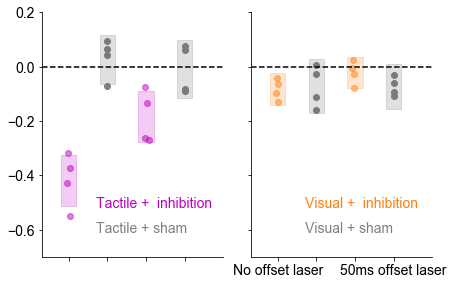

In [526]:
fig, (ax,ax1) = mpl.subplots(1,2, figsize = (7,4.5), sharey = True)
mean_diffs = mean_diffs[mean_diffs['mouse'] != 'YT045']

for a, mod, color in zip([ax,ax1], ['tac', 'vis'], ['m', 'C1']):
    for i, group in enumerate([mod+'_nolaser_0', mod+'_nolaser_50']):
        conf = [int(num_iter*0.025), int(num_iter*0.975)]
        a.scatter(np.random.randn(4)*0.025+i, mean_diffs.loc[mean_diffs['session'] == 'inh', group], color = color, alpha = 0.5)
        a.add_patch(patches.Rectangle((-0.1+i, inh_stats[group][conf[0]]), 0.2, inh_stats[group][conf[1]] - inh_stats[group][conf[0]], color = color, alpha = 0.2))

        a.scatter([0.5+i]*4, mean_diffs.loc[mean_diffs['session'] == 'sham', group], color = [0.5,0.5,0.5])
        a.add_patch(patches.Rectangle((0.4+i, sham_stats[group][conf[0]]), 0.2, sham_stats[group][conf[1]] - sham_stats[group][conf[0]], color = [0.4,0.4,0.4], alpha = 0.2))

ax.text(0.3, 0.1, 'Tactile + sham', transform = ax.transAxes, color = [0.5,0.5,0.5])
ax1.text(0.3, 0.1, 'Visual + sham', transform = ax1.transAxes, color = [0.5,0.5,0.5])

ax.text(0.3, 0.2, 'Tactile +  inhibition', transform = ax.transAxes, color = 'm')
ax1.text(0.3, 0.2, 'Visual +  inhibition', transform = ax1.transAxes, color = 'C1')
ax.set_xticks([0,0.5,1,1.5])
ax.set_xticklabels([])
ax1.set_xticks([0,0.5,1,1.5])

ax1.set_xticklabels(['No offset laser', '', '', '50ms offset laser'])

for a in (ax, ax1):
    utils.prettify_ax(a, x_label = '', y_label = '')
    a.axhline(0, linestyle = '--', color = 'k')
    a.set_xlim(-0.35,2)
    a.set_ylim(-0.7,0.2)
mpl.subplots_adjust(wspace = 0.15)    
fig.savefig('Fig8_inh_diff.pdf',format='pdf', dpi=900, transparent = True)

No laser/late inhibition t-test: 0.19218628711624366
No laser/full inhibition t-test: 0.01168997495201936



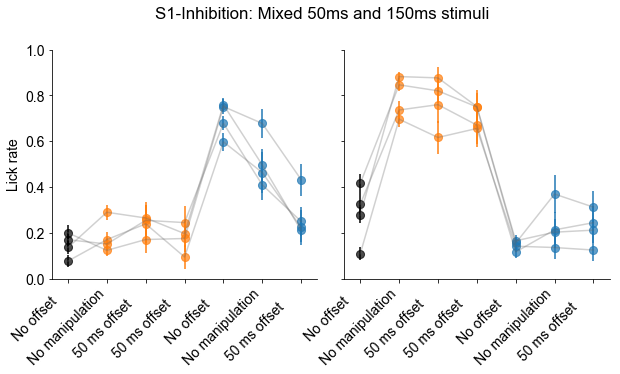

In [512]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize = (10,6), sharey = True)
plot_perf(beh_performance[('EF0114', 'inh')][0],beh_performance[('EF0114', 'inh')][1], ax1,ax2)
plot_perf(beh_performance[('EF0131', 'inh')][0],beh_performance[('EF0131', 'inh')][1], ax1,ax2)
plot_perf(beh_performance[('EF0132', 'inh')][0],beh_performance[('EF0132', 'inh')][1], ax1,ax2)
plot_perf(beh_performance[('EF0144', 'inh')][0],beh_performance[('EF0144', 'inh')][1], ax1,ax2)

fig.suptitle('S1-Inhibition: Mixed 50ms and 150ms stimuli')
# fig.savefig('fig_inh_both.png', format='png', dpi=600)

block_type = 'Visual'
stim_type = 'Stim_Vis'

cond1 = select_treatment_group(beh_performance, 'inh', (block_type, stim_type, 'No_laser'))
cond2 = select_treatment_group(beh_performance, 'inh', (block_type, stim_type, 0.05))
cond3 = select_treatment_group(beh_performance, 'inh', (block_type, stim_type, 0.0))
no_laser_vs_late = stats.ttest_rel(cond1, cond2)
no_laser_vs_full = stats.ttest_rel(cond1, cond3)

print('No laser/late inhibition t-test: {}\nNo laser/full inhibition t-test: {}\n'.format(no_laser_vs_late.pvalue/2, no_laser_vs_full.pvalue/2))
mpl.subplots_adjust(wspace = 0.1)
fig.savefig('S1-inh_mixed_long_short.pdf',format='pdf', dpi=900, transparent = True)